In [1]:
import pandas as pd
import numpy as np
import sys
import os
module_path = os.path.abspath(os.path.join(os.curdir))
if module_path not in sys.path:
    sys.path.append(module_path)

from hierarchical_helper import ClusterHelper
from hierarchical_helper import HierarchicalHelper
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20, 20)

## 获取数据

In [2]:
clusterAll = pd.read_csv('./data/opentsdb_L.csv', sep = ',',index_col=0).fillna(0)
clusterAll.head()

,L_mcrsvrmcrmres,L_mngsvrmngmres,L_mcrsvrallcode,L_mcrsvrcode4xxRateFail,L_mcrsvrcode5xxRateFail,L_mngsvrallcode,L_mngsvrcode4xxRateFail,L_mngsvrcode5xxRateFail,L_mjssvrcode5xxRateFail,L_mjssvrallcode,L_mjssvrcode4xxRateFail
1557936000,169.000,227.000,30097.0,0.7675,0.0,111675.0,0.9993,0.0385,0.0,37314.0,1.4579
1557936300,193.007,220.081,24786.0,1.3879,0.0,150383.0,0.8319,0.0193,0.0,53820.0,0.9643
1557936600,178.926,216.718,8982.0,1.6255,0.0,60832.0,1.5748,0.0247,0.0,20912.0,2.5105
1557936900,177.255,223.151,7903.0,1.7841,0.0,46323.0,2.2235,0.0367,0.0,14538.0,3.7901
1557937200,197.808,229.000,7524.0,1.6348,0.0,41009.0,2.1581,0.0317,0.0,13503.0,4.1102


In [3]:
def customizedStandardize(df, startIndex):
    temp = df.reset_index()
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(temp.iloc[:,range(startIndex,temp.columns.size)])
    data = pd.DataFrame(scaler.transform(temp.iloc[:,range(startIndex,temp.columns.size)]))
    return pd.DataFrame(data.values, columns=df.columns[startIndex - 1:len(df.columns)], index = df.index)

In [4]:
clusterAllStd = customizedStandardize(clusterAll,1)
clusterAllStd.head()

,L_mcrsvrmcrmres,L_mngsvrmngmres,L_mcrsvrallcode,L_mcrsvrcode4xxRateFail,L_mcrsvrcode5xxRateFail,L_mngsvrallcode,L_mngsvrcode4xxRateFail,L_mngsvrcode5xxRateFail,L_mjssvrcode5xxRateFail,L_mjssvrallcode,L_mjssvrcode4xxRateFail
1557936000,-0.586778,-0.190892,2.882371,-1.529335,0.0,1.871348,-0.810225,0.392455,-0.282314,1.686361,-1.366540
1557936300,-0.407469,-0.390849,2.152319,-0.726144,0.0,2.912769,-1.131926,-0.426643,-0.282314,2.990162,-1.780287
1557936600,-0.512640,-0.488039,-0.020103,-0.418539,0.0,0.503441,0.295739,-0.196272,-0.282314,0.390774,-0.484226
1557936900,-0.525121,-0.302127,-0.168423,-0.213210,0.0,0.113083,1.542374,0.315664,-0.282314,-0.112705,0.588364
1557937200,-0.371610,-0.133092,-0.220520,-0.406499,0.0,-0.029887,1.416692,0.102358,-0.282314,-0.194459,0.856679


## 建模

In [5]:
def modeling(df):
    from dtaidistance import dtw
    import numpy as np
    series = np.matrix(df.T)
    dist_matrix = dtw.distance_matrix_fast(series)
    from dtaidistance import clustering
    model3 = clustering.LinkageTree(dtw.distance_matrix_fast, {})
    model3.fit(series)
    return dist_matrix,model3

In [6]:
dist_matrix,model = modeling(clusterAllStd)

## 聚类展示

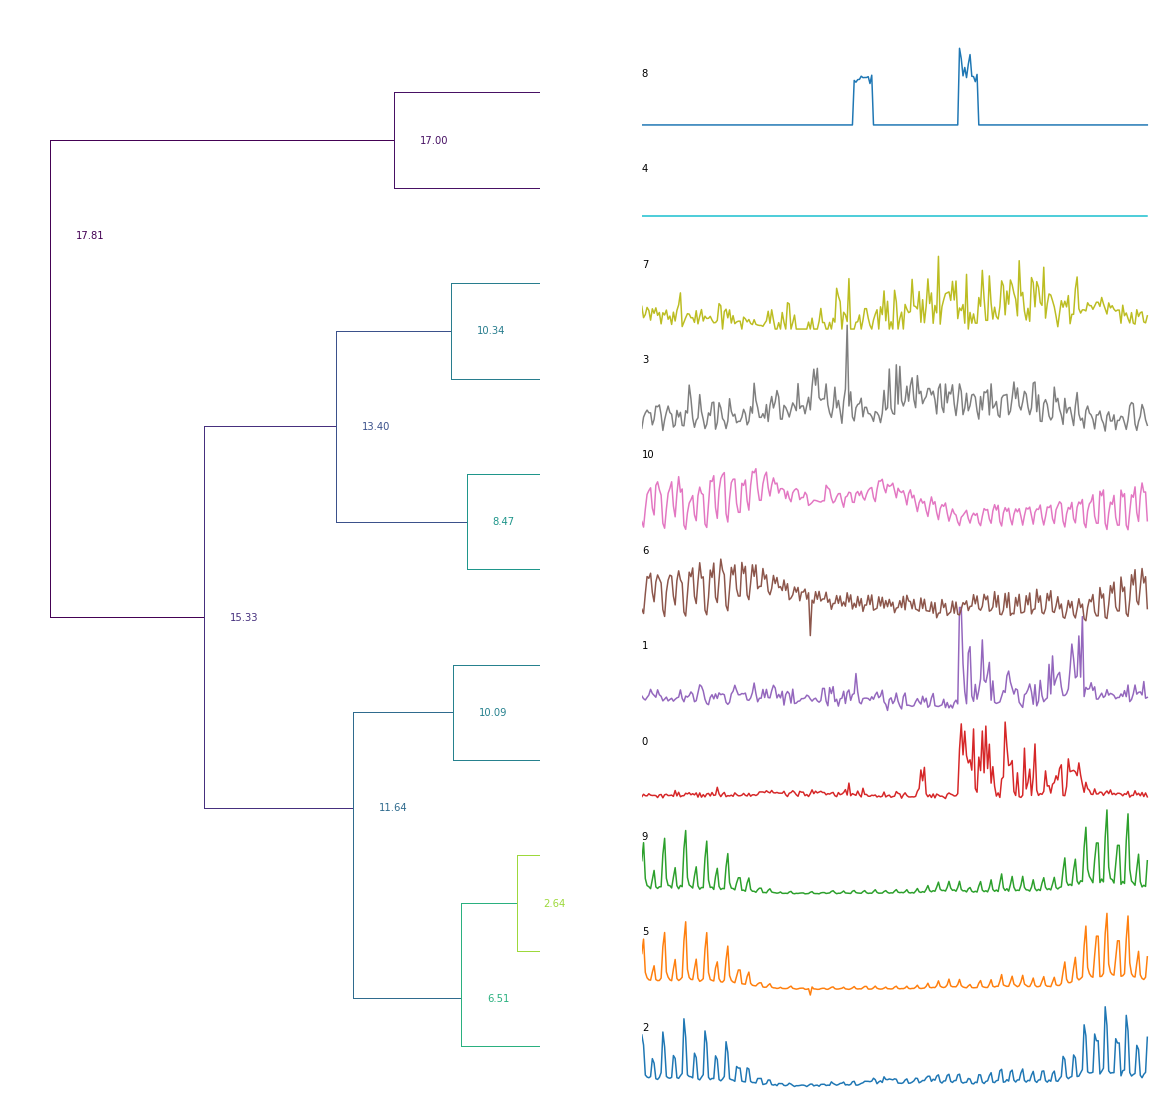

In [8]:
model.plot(show_ts_label=True, show_tr_label = True)
model.plot(filename = "./export/clustered.png", show_ts_label=True, show_tr_label = True)
plt.show()

## 构建自定义树结构


In [9]:
tree_helper = HierarchicalHelper(model)
# 打印节点，判断是不是叶节点
print(tree_helper.root, tree_helper.root.isLeaf())
print(tree_helper.root.left_node, tree_helper.root.left_node.isLeaf())
print(tree_helper.root.right_node, tree_helper.root.right_node.isLeaf())

<TreeNode: idx: 20, data: [17.814668802587022, 11.0]> False
<TreeNode: idx: 18.0, data: [15.32605321490102, 9.0]> False
<TreeNode: idx: 19.0, data: [16.99999999999998, 2.0]> False


## 建立子节点到父节点的映射


In [11]:
cls_helper = ClusterHelper(model, clusterAll.shape[1])
print("原来的节点关系：")
print(model.to_dot())
print("自定义的节点关系：")
print(cls_helper.toMap())

原来的节点关系：
digraph tree {
  20 -> 18.0;
  20 -> 19.0;
  18.0 -> 16.0;
  18.0 -> 17.0;
  19.0 -> 4.0;
  19.0 -> 8.0;
  16.0 -> 12.0;
  16.0 -> 14.0;
  17.0 -> 13.0;
  17.0 -> 15.0;
  12.0 -> 2.0;
  12.0 -> 11.0;
  14.0 -> 0.0;
  14.0 -> 1.0;
  13.0 -> 6.0;
  13.0 -> 10.0;
  15.0 -> 3.0;
  15.0 -> 7.0;
  11.0 -> 5.0;
  11.0 -> 9.0;
}
自定义的节点关系：
{18.0: 20, 19.0: 20, 16.0: 18.0, 17.0: 18.0, 4.0: 19.0, 8.0: 19.0, 12.0: 16.0, 14.0: 16.0, 13.0: 17.0, 15.0: 17.0, 2.0: 12.0, 11.0: 12.0, 0.0: 14.0, 1.0: 14.0, 6.0: 13.0, 10.0: 13.0, 3.0: 15.0, 7.0: 15.0, 5.0: 11.0, 9.0: 11.0}


## 根据指定类别数，返回所有类别


In [12]:
cluster_keys = tree_helper.getClusterByNum(tree_helper.root, 3, {})
for i in cluster_keys:
    print(i)

<TreeNode: idx: 18.0, data: [15.32605321490102, 9.0]>
<TreeNode: idx: 4.0, data: None>
<TreeNode: idx: 8.0, data: None>


## 根据指定最小距离，返回所有类别

In [13]:
cluster_keys = tree_helper.getClusterByDist(tree_helper.root, 6, {})
for i in cluster_keys:
    print(i)

<TreeNode: idx: 4.0, data: None>
<TreeNode: idx: 8.0, data: None>
<TreeNode: idx: 3.0, data: None>
<TreeNode: idx: 7.0, data: None>
<TreeNode: idx: 0.0, data: None>
<TreeNode: idx: 1.0, data: None>
<TreeNode: idx: 6.0, data: None>
<TreeNode: idx: 10.0, data: None>
<TreeNode: idx: 2.0, data: None>
<TreeNode: idx: 11.0, data: [2.639255505011694, 2.0]>


## 返回一个节点下所有子节点

In [14]:
nodes = []
tree_helper.iterTree(tree_helper.root.right_node, nodes)
for node in nodes:
    print(node)

<TreeNode: idx: 4.0, data: None>
<TreeNode: idx: 8.0, data: None>


## 距离上：一个metrix最像的N个metric

In [19]:
import heapq

metric_idx = 10
topN = 5

col_ls = dist_matrix[:, metric_idx]
raw_ls = dist_matrix[metric_idx]
concat_ls = np.hstack([col_ls,raw_ls])

print(concat_ls)

[12.82081518 14.23629404 15.32605321 11.46545206 17.         14.86819069
  8.47168665 12.79612125 17.8146688  15.30552235         inf         inf
         inf         inf         inf         inf         inf         inf
         inf         inf         inf         inf]


In [20]:
filter_concat_ls = np.insert(concat_ls[~np.isinf(concat_ls)], [metric_idx], 0).tolist()
print(filter_concat_ls)

[12.82081518254302, 14.236294040573057, 15.32605321490102, 11.465452055070681, 17.00000000000001, 14.868190685937723, 8.47168665188485, 12.79612124656529, 17.814668802587022, 15.305522345051452, 0.0]


In [21]:
re1 = list(map(filter_concat_ls.index, heapq.nsmallest(topN, filter_concat_ls)))
print(re1)

[10, 6, 3, 7, 0]


## 一个metrix 上N层的类

In [24]:
metric_idx = 10

print(tree_helper.idx_node_map.get(metric_idx))
print(tree_helper.idx_node_map.get(metric_idx).parrent_node)
print(tree_helper.idx_node_map.get(metric_idx).parrent_node.parrent_node)

<TreeNode: idx: 10.0, data: None>
<TreeNode: idx: 13.0, data: [8.47168665188485, 2.0]>
<TreeNode: idx: 17.0, data: [13.397772091967907, 4.0]>
